In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
import seaborn as sns

In [2]:
@dataclass
class StoreSpec:
    mean_customers_mu: float = 1000.0
    mean_customers_sigma: float = 500.0
    std_over_mean_customers: float = 0.2

@dataclass
class ProductCategorySpec:
    list_elasticity_mu: list[float] = field(default_factory=lambda: [-0.7, -1.2, -1.7])
    elasticity_std: float = 0.2
    list_size: list[float] = field(default_factory=lambda: [0.1, 0.3, 1.0])
    list_price_per_size_mu: list[float] = field(default_factory=lambda: [1.0, 3.0, 9.0])
    price_per_size_sigma_rel: float = 0.1
    base_demand_min: float = 0.1
    base_demand_max: float = 0.3
    promo_freq: float = 0.1
    list_promo_lift: list[float] = field(default_factory=lambda: [0.1, 0.2, 0.4])

@dataclass
class ProductSpec:
    elasticity_sigma: float = 0.1
    list_size_mult: list[float] = field(default_factory=lambda: [0.5, 1.0, 2.0])
    price_size_discount_power: float = 0.2
    price_sigma_rel: float = 0.1
    list_promo_lift_mult: list[float] = field(default_factory=lambda: [0.8, 1.0, 1.2])


class SalesDataGenerator:
    def __init__(
        self,
        n_stores: int,
        n_product_categories: int,
        n_products: int,
        product_spec: ProductSpec = ProductSpec(),
        store_spec: StoreSpec = StoreSpec(),
        product_cat_spec: ProductCategorySpec = ProductCategorySpec(),
        log_sales_sigma: float = 0.05,
        seed: int = 42

    ):
        self.n_stores = n_stores
        self.n_product_categories = n_product_categories
        self.n_products = n_products
        self.product_cat_spec = product_cat_spec
        self.store_spec = store_spec
        self.seed = seed
        self.product_spec = product_spec
        self.log_sales_sigma = log_sales_sigma

    def generate(self, num_weeks: int, start_date: str = '2020-01-06'):
        np.random.seed(self.seed)
        df_dates = self._generate_df_dates(num_weeks, start_date)
        df_stores = self._generate_df_stores()
        df_stores_dates = df_stores.merge(df_dates, how='cross')
        df_stores_dates['n_customers'] = self._generate_n_customers(df_stores_dates)
        df_product_cats = self._generate_df_product_cats()
        df_products = self._generate_df_products(df_product_cats)
        df_final = df_stores_dates.merge(df_products, how='cross')
        df_final['promo_freq'] = self._generate_promo_freq(df_final)
        df_final['promo_flag'] = self._generate_promo_flag(df_final)
        df_final['promo_discount'] = self._generate_promo_discount(df_final)
        df_final['price'] = self._generate_price(df_final)
        df_final['price_per_size'] = df_final['price'] / df_final['product_size']
        df_final['sales'] = self._generate_sales(df_final)
        

        return df_final

    def _generate_df_stores(self):
        np.random.seed(self.seed)
        stores = []
        for store_id in range(1, self.n_stores + 1):
            mean_customers = np.random.normal(
                loc=self.store_spec.mean_customers_mu,
                scale=self.store_spec.mean_customers_sigma
            )
            std_customers = mean_customers * self.store_spec.std_over_mean_customers
            stores.append({
                'store_id': store_id,
                'store_mean_customers': mean_customers,
                'store_std_customers': std_customers,
            })
        return pd.DataFrame(stores)

    def _generate_df_dates(self, num_weeks: int, start_date: str):
        dates = pd.date_range(start=start_date, periods=num_weeks, freq='W-MON')
        return pd.DataFrame({
            't': range(len(dates)),
            'date': dates
        })

    def _generate_n_customers(self, df):
        np.random.seed(self.seed)
        mu_t = df['store_mean_customers']
        sigma_t = df['store_std_customers']
        lambda_t = np.random.gamma(shape=mu_t ** 2 / sigma_t ** 2, scale=sigma_t ** 2 / mu_t)
        # shape and scale are set in a way that E[lambda_t] = mu_t and Var[lambda_t] = sigma_t^2
        N_t = np.random.poisson(lam=lambda_t)
        return N_t

    def _generate_df_product_cats(self):
        np.random.seed(self.seed)
        spec = self.product_cat_spec
        product_categories = []
        for category_id in range(1, self.n_product_categories + 1):
            elasticity = np.random.choice(spec.list_elasticity_mu)
            elasticity += np.random.normal(loc=0.0, scale=spec.elasticity_std)
            elasticity = np.clip(elasticity, -3.0, -0.1)
            price_per_size = np.random.choice(spec.list_price_per_size_mu)
            price_per_size += np.random.normal(
                loc=0.0,
                scale=price_per_size * spec.price_per_size_sigma_rel
            )
            base_demand = np.random.uniform(
                low=spec.base_demand_min,
                high=spec.base_demand_max
            )
            promo_freq = spec.promo_freq  # TODO: add noise
            promo_lift = np.random.choice(spec.list_promo_lift)
            product_categories.append({
                'product_cat_id': category_id,
                'product_cat_elasticity': elasticity,
                'product_cat_size': np.random.choice(spec.list_size),
                'product_cat_price_per_size': price_per_size,
                'product_cat_base_demand': base_demand,
                'product_cat_promo_freq': promo_freq, 
                'product_cat_promo_lift': promo_lift,
            })
        return pd.DataFrame(product_categories)

    def _generate_df_products(self, df_product_cats):
        np.random.seed(self.seed)
        spec = self.product_spec
        df = pd.DataFrame({
            'product_id': range(1, self.n_products + 1),
            'product_cat_id': np.random.choice(
                df_product_cats['product_cat_id'],
                size=self.n_products,
                replace=True
            )
        })
        df = df.merge(df_product_cats, on='product_cat_id', how='left')
        df['product_elasticity'] = (
            df['product_cat_elasticity']
            + np.random.normal(loc=0.0, scale=spec.elasticity_sigma, size=len(df))
        )
        df['product_elasticity'] = df['product_elasticity'].clip(-3.0, -0.1)
        df['product_size'] = (
            df['product_cat_size'] 
            * np.random.choice(spec.list_size_mult, size=len(df), replace=True)
        )
        df['product_price'] = df['product_cat_price_per_size'] * np.power(
            df['product_size'] / df['product_cat_size'], 1 - spec.price_size_discount_power
        )
        df['product_price'] *= 1 + np.random.normal(loc=0.0, scale=spec.price_sigma_rel, size=len(df))
        df['product_price'] = df['product_price'].clip(lower=0.1)
        df['product_base_demand'] = df['product_cat_base_demand'] / df['product_size']
        # TODO: add some noise to base demand
        promo_lift_mult = np.random.choice(spec.list_promo_lift_mult, size=len(df), replace=True)
        df['product_promo_lift'] = df['product_cat_promo_lift'] * promo_lift_mult
        return df

    def _generate_price(self, df):
        # TODO: New effect: prices are different in stores
        price = df['product_price'] * (1 - df['promo_discount'])
        return price.round(2).clip(lower=0.1)

    def _generate_promo_freq(self, df):
        # TODO: New effect: different frequencies depending on store
        return df['product_cat_promo_freq']

    def _generate_promo_flag(self, df):
        np.random.seed(self.seed)
        promo_flags = np.random.binomial(
            n=1,
            p=df['promo_freq'],
            size=len(df)
        )
        return promo_flags

    def _generate_promo_discount(self, df):
        # TODO: New effect: different discount depending on product
        return df['promo_flag'] * 0.1  # 10% discount if promo is active

    def _generate_sales(self, df):
        np.random.seed(self.seed)
        log_sales = (
            np.log(df['n_customers'])
            + np.log(df['product_base_demand'])
            - df['product_cat_elasticity'] * np.log(df['product_cat_price_per_size'])
            + df['product_elasticity'] * np.log(df['price_per_size'])
            + df['promo_flag'] * np.log1p(df['product_promo_lift'])
            + np.random.normal(loc=0.0, scale=self.log_sales_sigma, size=len(df))
        )
        return (np.exp(log_sales)).round().astype(int).clip(lower=0)

    # TODO: Effects that can be added later
    # - sales penalty for extra size
    # - promotional factor
    # - effect of promotion on price
    # - n_customers depends on time (trend)
    # - n_customers depends on time (seasonality)
    # - individual demands for products


In [3]:
gen = SalesDataGenerator(
    n_stores=5,
    n_product_categories=5,
    n_products=100,
)

In [4]:
df_final = gen.generate(num_weeks=26)
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    display(df_final)

,store_id,store_mean_customers,store_std_customers,t,date,n_customers,product_id,product_cat_id,product_cat_elasticity,product_cat_size,product_cat_price_per_size,product_cat_base_demand,product_cat_promo_freq,product_cat_promo_lift,product_elasticity,product_size,product_price,product_base_demand,product_promo_lift,promo_freq,promo_flag,promo_discount,price,price_per_size,sales
0,1,1248.357077,249.671415,0,2020-01-06,1381,1,4,-1.902566,0.3,9.282823,0.191214,0.1,0.4,-1.992200,0.60,13.935698,0.318690,0.32,0.1,0,0.0,13.94,23.233333,59
1,1,1248.357077,249.671415,0,2020-01-06,1381,2,5,-1.671507,1.0,0.996535,0.109290,0.1,0.4,-1.682706,2.00,1.572349,0.054645,0.48,0.1,1,0.1,1.42,0.710000,196
2,1,1248.357077,249.671415,0,2020-01-06,1381,3,3,-1.292684,0.1,2.860281,0.204951,0.1,0.1,-1.145789,0.10,3.007596,2.049513,0.10,0.1,0,0.0,3.01,30.100000,230
3,1,1248.357077,249.671415,0,2020-01-06,1381,4,5,-1.671507,1.0,0.996535,0.109290,0.1,0.4,-1.783897,0.50,0.601766,0.218580,0.32,0.1,0,0.0,0.60,1.200000,234
4,1,1248.357077,249.671415,0,2020-01-06,1381,5,5,-1.671507,1.0,0.996535,0.109290,0.1,0.4,-1.576507,2.00,1.824432,0.054645,0.48,0.1,0,0.0,1.82,0.910000,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,5,882.923313,176.584663,25,2020-06-29,1663,96,3,-1.292684,0.1,2.860281,0.204951,0.1,0.1,-1.280786,0.05,1.746236,4.099026,0.12,0.1,1,0.1,1.57,31.400000,350
12996,5,882.923313,176.584663,25,2020-06-29,1663,97,5,-1.671507,1.0,0.996535,0.109290,0.1,0.4,-1.571459,0.50,0.524911,0.218580,0.40,0.1,0,0.0,0.52,1.040000,338
12997,5,882.923313,176.584663,25,2020-06-29,1663,98,2,-1.384157,0.3,3.230230,0.111282,0.1,0.2,-1.368915,0.15,1.751351,0.741882,0.20,0.1,0,0.0,1.75,11.666667,211
12998,5,882.923313,176.584663,25,2020-06-29,1663,99,2,-1.384157,0.3,3.230230,0.111282,0.1,0.2,-1.444297,0.60,6.044448,0.185471,0.24,0.1,0,0.0,6.04,10.066667,60


In [5]:
cols_observable = [
    'store_id',
    'product_id',
    'product_cat_id',
    'date',
    'product_size',
    'promo_flag',
    'price',
    'sales'
]

# Save dataset

In [6]:
df_final[cols_observable].to_parquet('synthetic_sales_data.pq', index=False)

In [7]:
df_final.to_parquet('synthetic_sales_data_with_latent.pq', index=False)

# Explore

In [8]:
df_final = pd.read_parquet('synthetic_sales_data_with_latent.pq')

In [9]:
df_final.groupby('product_cat_id').agg(
    **{
        'n_products': ('product_id', 'nunique'),
        'product_cat_base_demand': ('product_cat_base_demand', 'first'),
    }
)

,n_products,product_cat_base_demand
product_cat_id,,
1,18,0.219370
2,21,0.111282
3,16,0.204951
4,26,0.191214
5,19,0.109290


In [10]:
df_final['promo_flag'].mean()

np.float64(0.09761538461538462)

-0.640467361604893


[None]

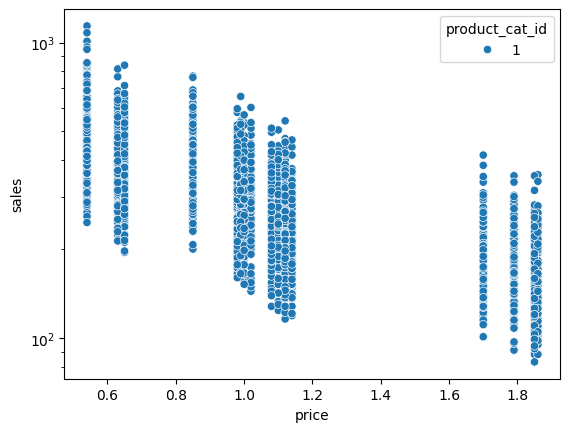

In [11]:
df = df_final.loc[lambda df: (df['product_cat_id'] == 1) & (df['promo_flag'] == 0)]
# df = df_final
col1, col2 = 'price', 'sales'
print(df[col1].corr(df[col2]))
ax = sns.scatterplot(data=df, x=col1, y=col2, hue='product_cat_id')
ax.set(yscale='log')

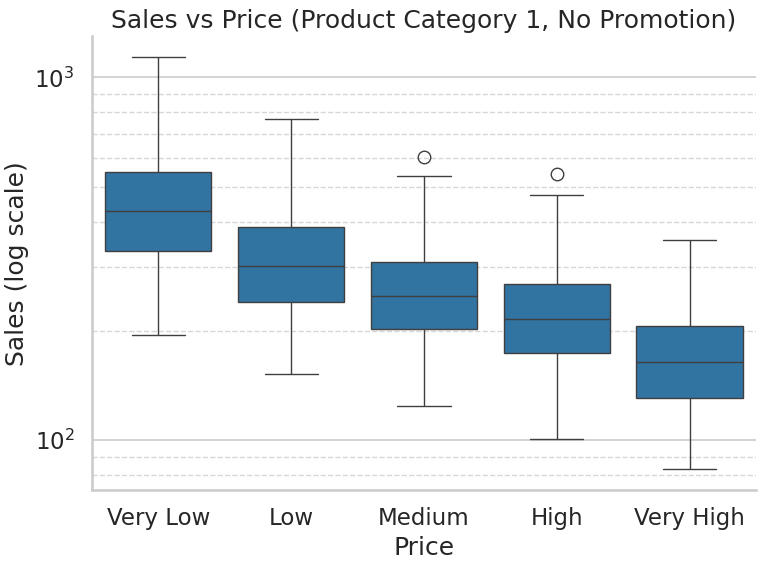

In [12]:
df = df_final.loc[lambda df: (df['product_cat_id'] == 1) & (df['promo_flag'] == 0)]
bin_labels = ["Very Low", "Low", "Medium", "High", "Very High"]
# bin_labels=None
df = df.assign(**{'price_bin': pd.qcut(df['price'], 5, labels=bin_labels)})
# df["price_bin"] = df['price_bin'].cat.rename_categories(
#     lambda x: f"{x.left:.2f}–{x.right:.2f}"
# )
with sns.axes_style("whitegrid"), sns.plotting_context("talk"):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax = sns.boxplot(data=df, x='price_bin', y='sales', log_scale=(False, True), ax=ax)
    # ax = sns.stripplot(
    #     data=df,
    #     x="price_bin",
    #     y="sales",
    #     dodge=True,
    #     alpha=0.3,
    #     size=3,
    #     color="0.3",   # neutral grey
    #     ax=ax
    # )
    ax.set_ylabel("Sales (log scale)")
    ax.set_xlabel("Price")
    ax.set_title("Sales vs Price (Product Category 1, No Promotion)")
    ax.minorticks_on()
    ax.grid(which="major", linestyle="-", linewidth=1.2, axis='y')
    ax.grid(which="minor", linestyle="--", linewidth=1.0, alpha=0.8, axis='y')
    sns.despine()
    fig.tight_layout()

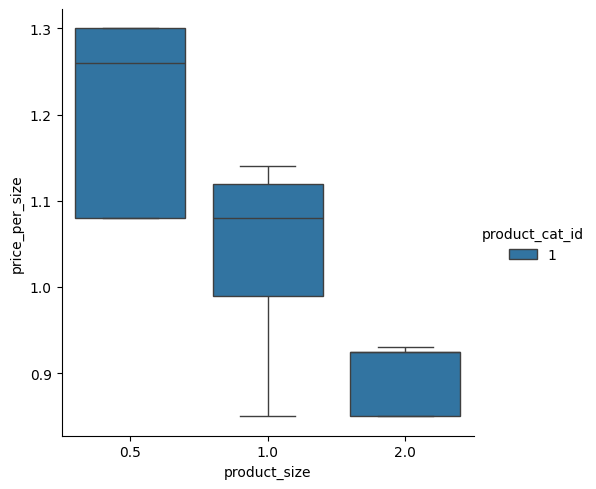

In [13]:
df = df_final.loc[lambda df: (df['promo_flag'] == 0) & (df['product_cat_id'] == 1)]
# df = df_final
# ax = sns.boxplot(data=df, x='product_size', y='price')
# ax = sns.scatterplot(data=df, x='product_size', y='price_per_size', hue='product_cat_id')
ax = sns.catplot(data=df, x='product_size', y='price_per_size', hue='product_cat_id', kind='box')
# ax.set(xscale='log')

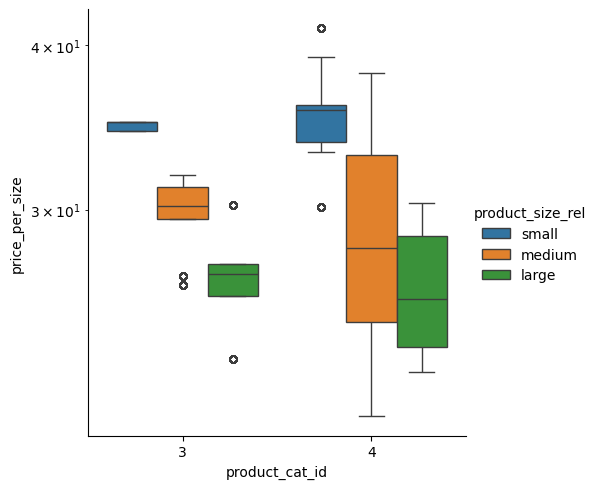

In [14]:
df = df_final.loc[lambda df: (df['promo_flag'] == 0) & (df['product_cat_id'].isin([3, 4]))]
df = df.assign(**{
    'product_size_rel': pd.cut(
        df['product_size'] / df['product_cat_size'],
        bins=[0.0, 0.7, 1.5, np.inf],
        labels=['small', 'medium', 'large']
    ),
    'price_per_size_over_cat': df['price_per_size'] / df['product_cat_price_per_size'],
})
# df = df.drop_duplicates(subset=['product_cat_id', 'product_size_rel', 'price_per_size_over_cat', 'price_per_size'])

sns.catplot(data=df, x='product_cat_id', y='price_per_size', hue='product_size_rel', kind='box', log_scale=True)

<Axes: >

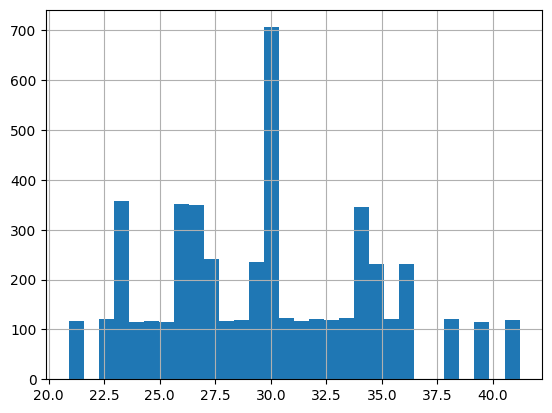

In [15]:
df['price_per_size'].hist(bins=30)

<Axes: >

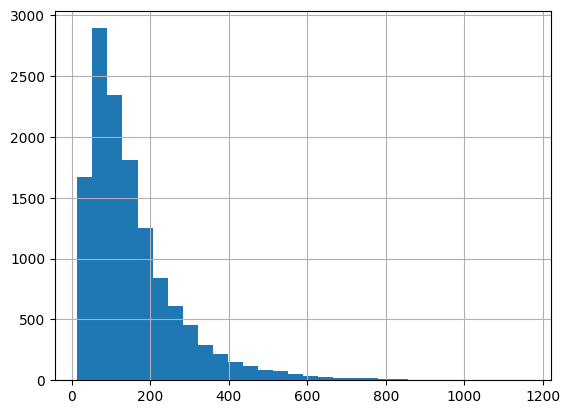

In [16]:
df_final['sales'].hist(bins=30)

<Axes: >

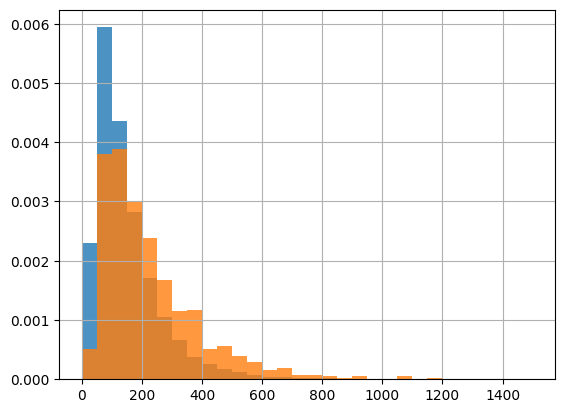

In [17]:
df = df_final#.loc[lambda df: df['product_id'] == 1]
df.loc[lambda df: df['promo_flag'] == 0]['sales'].hist(bins=30, alpha=0.8, density=True, range=(0, 1500))
df.loc[lambda df: df['promo_flag'] == 1]['sales'].hist(bins=30, alpha=0.8, density=True, range=(0, 1500))

<Axes: xlabel='promo_flag', ylabel='sales'>

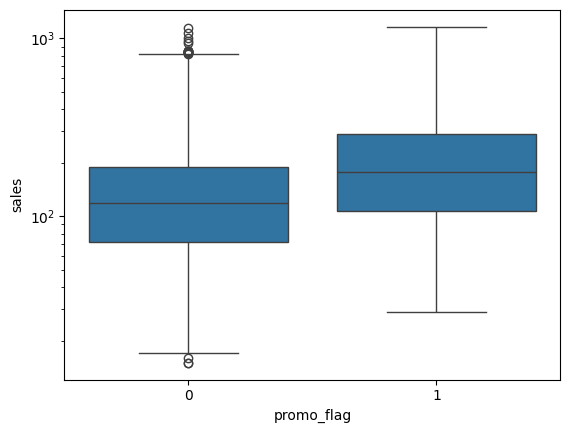

In [18]:
sns.boxplot(data=df_final, x='promo_flag', y='sales', log_scale=True)

(0.0, 1029.0)

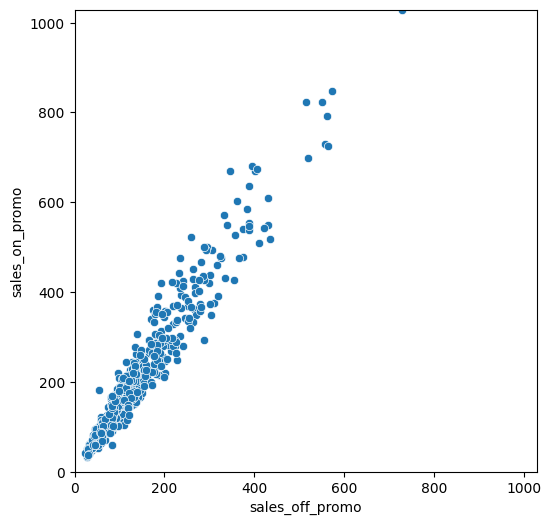

In [19]:
df = (
    df_final
    .assign(
        off_promo_flag=lambda df: 1 - df['promo_flag'],
        sales_on_promo=lambda df: df['sales'] * df['promo_flag'],
        sales_off_promo=lambda df: df['sales'] * df['off_promo_flag'],
    )
    .groupby(['product_id', 'store_id'])
    .agg(**{
        col: (col, 'sum') for col in ['sales_on_promo', 'sales_off_promo']
    }, **{
        'n_weeks_on_promo': ('promo_flag', 'sum'),
        'n_weeks_off_promo': ('off_promo_flag', 'sum')
    })
    .assign(**{
        'sales_on_promo': lambda df: df['sales_on_promo'] / df['n_weeks_on_promo'],
        'sales_off_promo': lambda df: df['sales_off_promo'] / df['n_weeks_off_promo'],
    })
    .loc[lambda df: (df['n_weeks_on_promo'] > 0) & (df['n_weeks_off_promo'] > 0)]
    .assign(lift_prc = lambda df: df['sales_on_promo'] / df['sales_off_promo'] - 1)
)
# df
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(data=df, x='sales_off_promo', y='sales_on_promo')
ax.set_aspect('equal', adjustable='box')
limit = max(max(abs(df['sales_off_promo'])), max(abs(df['sales_on_promo'])))
ax.set_xlim(0, limit)
ax.set_ylim(0, limit)
# df['lift_prc'].hist(bins=20)

<Axes: >

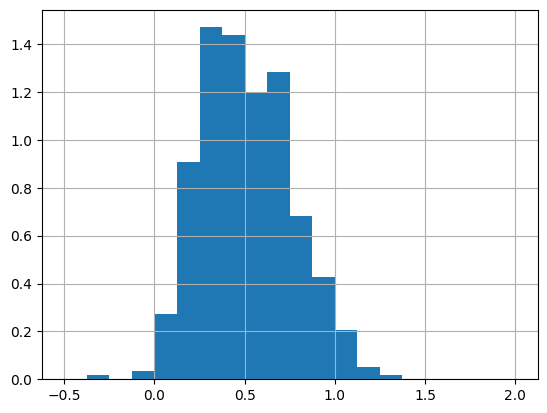

In [20]:
df['lift_prc'].hist(bins=20, range=(-0.5, 2.0), density=True)

<Axes: xlabel='promo_flag', ylabel='price'>

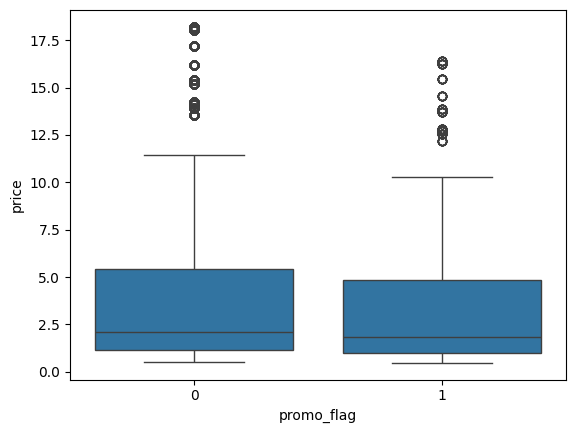

In [21]:
sns.boxplot(data=df_final, x='promo_flag', y='price')

<Axes: >

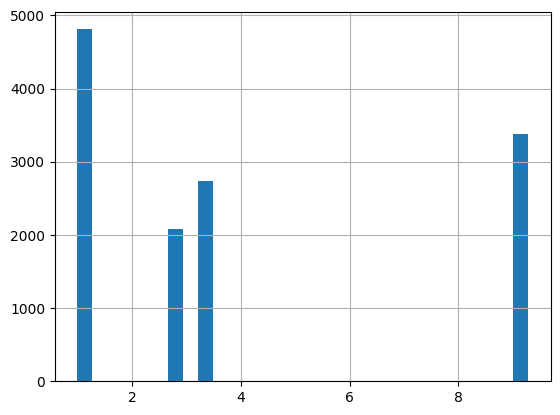

In [22]:
df_final['product_cat_price_per_size'].hist(bins=30)